In [1]:
import itertools
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.extmath import cartesian
from scipy.linalg import block_diag
from sys import exit

In [2]:
import argparse
parser = argparse.ArgumentParser(description='Process some integers.')
parser.add_argument('-f') # jupyter
parser.add_argument('--n_documents', type=int, default=10,
                   help='number of documents to collect data for')
parser.add_argument('--model', type=str, default="skipthoughts")
args = parser.parse_args()
n_articles = args.n_documents
model = args.model

In [3]:
n_articles = 10
model = "dissent"

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R -i n_articles
library(tidyverse)
library(Hmisc)
library(ggthemes)

/home/erindb/miniconda2/envs/dod/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

  warnings.warn(x, RRuntimeWarning)
/home/erindb/miniconda2/envs/dod/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: ✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0

  warnings.warn(x, RRuntimeWarning)
/home/erindb/miniconda2/envs/dod/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

  warnings.warn(x, RRuntimeWarning)
/home/erindb/miniconda2/envs/dod/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: lattice

  warnings.warn(x, RRuntime

# Distances between sentences

In [6]:
# load embeddings and metadata and
# compute distances between sentences
def get_distances(model, dataset):
    input_matrix_file = "../data/%s/%s_%s_%d.npy" %(dataset, dataset, model, n_articles)
    input_data_file = "../data/%s/%s_reformatted_%d.csv" %(dataset, dataset, n_articles)
    # load data
    df = pd.read_csv(input_data_file)
    # load embeddings
    embeddings = np.load(input_matrix_file)
    distances = 1 - cosine_similarity(embeddings)
    displacements = embeddings[1:] - embeddings[:-1]
    return df, distances, displacements

df, distances, displacements = get_distances(model, "wiki")

## Within vs across documents

How similar do sentences from the same document tend to be? How similar do sentences from different documents tend to be?

The similarity due to being in the same document gives us some sense of overall topic similarity.

Take any two unique sentences in the dataset, either from the same document or different documents, and measure the distance between them.

In [7]:
distances.shape

(996, 996)

In [8]:
def make_block(N):
    x = np.ones((N, N), dtype=bool)
    return x

# computing mask should be at least as fast as cosine similarity, right?
# it is, at least for 100 docs
def get_doc_masks(df, distances, mask_id="doc_id", diff_mask=True):
    number_of_sentences_per_doc = df.groupby(mask_id).apply(lambda x: len(x.s_id))
    document_blocks = number_of_sentences_per_doc.apply(make_block)
    same_doc_mask = block_diag(*document_blocks)
    if diff_mask:
        diff_doc_mask = np.logical_not(same_doc_mask)
    # upper diagonals, so we ignore same sentences
    same_doc_mask = np.triu(same_doc_mask, 1)
    if diff_mask:
        diff_doc_mask = np.triu(diff_doc_mask, 1)
        return same_doc_mask, diff_doc_mask
    else:
        return same_doc_mask

def make_df_from_distances(labeled_arrays):
    unique_labels = list(labeled_arrays.keys())
    distance_arrays = list(labeled_arrays.values())
    labels = np.repeat(unique_labels, [len(da) for da in distance_arrays])
    distances = np.concatenate(distance_arrays)
    return pd.DataFrame({"pair_type": labels, "distance": distances})
   
def within_vs_across_docs(df):
    # are they (different sentences and) in the same document?
    same_doc, diff_doc = get_doc_masks(df, distances)
    # mask by whether distances are in the same document
    same_doc = distances[same_doc]
    diff_doc = distances[diff_doc]
    # create dataframe
    doc_dist_df = make_df_from_distances({"Same Document": same_doc, "Different Document": diff_doc})
    doc_dist_means = doc_dist_df.groupby("pair_type").mean()
    return doc_dist_means, doc_dist_df

doc_dist_means, doc_dist_df = within_vs_across_docs(df)
doc_dist_means

,distance
pair_type,
Different Document,0.532293
Same Document,0.503514


In [9]:
# %%R -i doc_dist_df -i model -w 300 -h 200 -u px
# p = doc_dist_df %>%
# ggplot(aes(x = pair_type, y = distance)) +
# stat_summary(fun.y = mean, geom = "bar", fill = "gray", colour = "black") +
# stat_summary(fun.data = mean_cl_boot, geom = "errorbar", colour="black", width = 0.1) +
# ylab("Cosine Distance") +
# xlab("Sentence Pair") +
# theme_few(12)
# print(p)
# ggsave(paste("within_vs_across_documents_", model, "_", n_articles, ".png", sep=""))

In [10]:
# # sanity check that nothing is in the same doc *and* a different doc
# same_doc, diff_doc = get_doc_masks(df, distances)
# assert(np.sum((same_doc == diff_doc) & (same_doc != 0)) == 0)

In [11]:
# from scipy import stats
# stats.ttest_ind(doc_dist_df[doc_dist_df['pair_type']=='Same Document']['distance'],
#                 doc_dist_df[doc_dist_df['pair_type']=='Different Document']['distance'], equal_var=False)

## Within-documents

How does the distances between two unique sentences in the same paragraph vary as a function of how far apart they are in the paragraph?

How far from the first sentence is each subsequent sentence in the paragraph?

In [12]:
# get distances and data for all within-document pairs

# get all sentence pairs
sentence_pair_indices = cartesian((df.s_id,df.s_id))
# get same document mask
same_doc = get_doc_masks(df, distances, "doc_id", diff_mask=False)
# filter distances to only unique sentences in the same document
increments = distances[same_doc]

col_names = [n for n in list(df.keys()) if not n in ["Unnamed: 0", "sec_title"]]
within_doc_df = {}
for s in [0, 1]:
    # get sentence ideas for (start|end) sentence of the pair
    s_ids = sentence_pair_indices[:,s]
    # filter distances to only unique sentences in the same document
    s_ids.shape = distances.shape
    s_ids = s_ids[same_doc]
    # get column values for those within-document sentence pairs
    for var in col_names:
        new_var = "%s_%s" %(("start" if s==0 else "end"), var)
        within_doc_df[new_var] = df.loc[s_ids][var].values

within_doc_df = pd.DataFrame(within_doc_df)
within_doc_df["distance"] = increments
within_doc_df["s_separation"] = (within_doc_df.end_s_id - within_doc_df.start_s_id)
within_doc_df["same_par"] = (within_doc_df.end_par_id == within_doc_df.start_par_id)

In [13]:
%%R -i within_doc_df -i doc_dist_means -i model
# how many paragraphs have this length?
within_doc_df = within_doc_df %>%
group_by(end_n_s_in_par) %>%
mutate(n_pars_with_this_length = length(unique(end_par_id))) %>%
as.data.frame() %>%
mutate(end_par_location = ifelse(
    end_par_in_doc == 0,
    "First paragraph",
    ifelse(end_par_in_doc == (end_n_par_in_doc - 1),
           "Last paragraph",
           "Other paragraphs"))) %>%
group_by(end_par_location) %>%
mutate(end_n_pars_at_this_location = length(unique(end_par_id))) %>%
as.data.frame()

/home/erindb/miniconda2/envs/dod/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [14]:
%%R
mean_within_paragraph_distance = within_doc_df %>%
filter(same_par) %>%
summarise(mean_distance = mean(distance)) %>%
.[1, "mean_distance"]

/home/erindb/miniconda2/envs/dod/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Saving 3.47 x 2.78 in image

  warnings.warn(x, RRuntimeWarning)


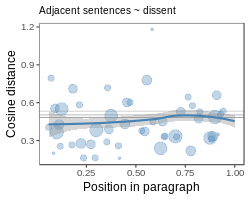

In [15]:
%%R -w 250 -h 200 -u px
p = within_doc_df %>%
filter(s_separation == 1) %>%
filter(same_par) %>%
mutate(par_position = end_s_in_par / (end_n_s_in_par - 1)) %>%
ggplot(., aes(x = par_position,
              y = distance,
              size = n_pars_with_this_length)) +
geom_hline(yintercept = mean_within_paragraph_distance, colour="darkgray") +
geom_hline(yintercept = doc_dist_means["Same Document","distance"], colour="gray") +
geom_hline(yintercept = doc_dist_means["Different Document","distance"], colour="lightgray") +
stat_summary(fun.y = mean, geom = "point", colour="steelblue", alpha=1/3) +
# stat_summary(fun.data = mean_cl_boot, geom = "errorbar", width=0) +
geom_smooth(method="loess", group=1, colour="steelblue") +
xlab("Position in paragraph") +
ylab("Cosine distance") +
ggtitle(paste("Adjacent sentences ~ ", model, sep="")) +
theme_few(12) +
theme(legend.position="none") +
theme(plot.title=element_text(size=10))
print(p)
ggsave(paste("../img/within_par_increments_", model, "_", n_articles, ".png", sep=""))

/home/erindb/miniconda2/envs/dod/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Saving 6.25 x 2.78 in image

  warnings.warn(x, RRuntimeWarning)


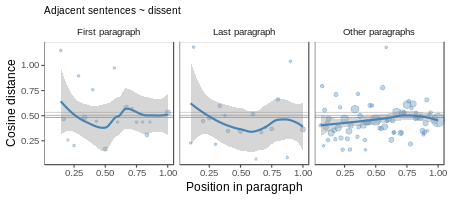

In [16]:
%%R -w 450 -h 200 -u px
p = within_doc_df %>%
filter(s_separation == 1) %>%
filter(same_par) %>%
mutate(par_position = end_s_in_par / (end_n_s_in_par - 1)) %>%
group_by(par_position, end_par_location) %>%
mutate(N_pairs = length(unique(end_s_id))) %>%
ggplot(., aes(x = par_position,
              y = distance,
              size = N_pairs)) +
geom_hline(yintercept = mean_within_paragraph_distance, colour="darkgray") +
geom_hline(yintercept = doc_dist_means["Same Document","distance"], colour="gray") +
geom_hline(yintercept = doc_dist_means["Different Document","distance"], colour="lightgray") +
stat_summary(fun.y = mean, geom = "point", colour="steelblue", alpha=1/3) +
# stat_summary(fun.data = mean_cl_boot, geom = "errorbar", width=0, colour="steelblue", size=0.1, alpha=1/3) +
geom_smooth(method="loess", group=1, colour="steelblue", size=1) +
xlab("Position in paragraph") +
ylab("Cosine distance") +
ggtitle(paste("Adjacent sentences ~ ", model, sep="")) +
theme(legend.position="none") +
facet_wrap(~end_par_location) +
theme_few(12) +
theme(legend.position="none") +
theme(plot.title=element_text(size=10))
print(p)
ggsave(paste("../img/within_par_increments_by_location_", model, "_", n_articles, ".png", sep=""))

/home/erindb/miniconda2/envs/dod/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Saving 8.33 x 8.33 in image

  warnings.warn(x, RRuntimeWarning)


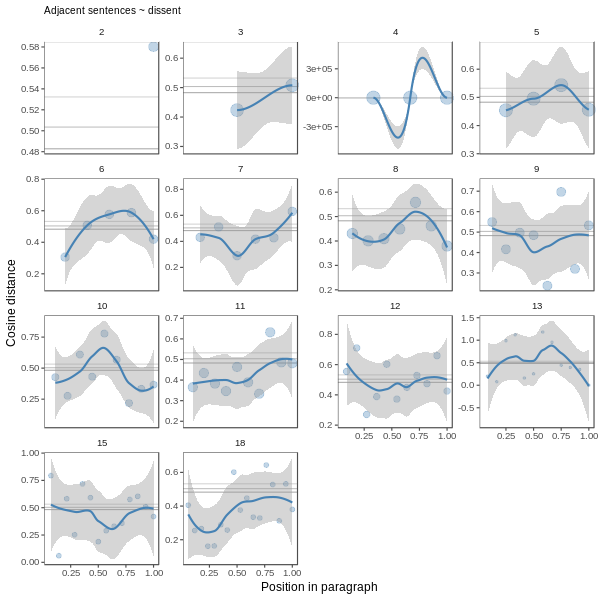

In [17]:
%%R -w 600 -h 600 -u px
p = within_doc_df %>%
filter(s_separation == 1) %>%
filter(same_par) %>%
filter(end_n_s_in_par > 1) %>%
mutate(par_position = end_s_in_par / (end_n_s_in_par - 1)) %>%
group_by(par_position, end_n_s_in_par) %>%
mutate(N_pairs = length(unique(end_s_id))) %>%
as.data.frame() %>%
ggplot(., aes(x = par_position,
              y = distance,
              size = N_pairs)) +
geom_hline(yintercept = mean_within_paragraph_distance, colour="darkgray") +
geom_hline(yintercept = doc_dist_means["Same Document","distance"], colour="gray") +
geom_hline(yintercept = doc_dist_means["Different Document","distance"], colour="lightgray") +
stat_summary(fun.y = mean, geom = "point", colour="steelblue", alpha=1/3) +
# stat_summary(fun.data = mean_cl_boot, geom = "errorbar", width=0, colour="steelblue", size=1, alpha=1/3) +
geom_smooth(method="loess", group=1, colour="steelblue", size=1) +
xlab("Position in paragraph") +
ylab("Cosine distance") +
ggtitle(paste("Adjacent sentences ~ ", model, sep="")) +
theme(legend.position="none") +
facet_wrap(~end_n_s_in_par, scale="free_y") +
theme_few(12) +
theme(legend.position="none") +
theme(plot.title=element_text(size=10))
print(p)
ggsave(paste("../img/within_par_increments_by_length_", model, "_", n_articles, ".png", sep=""))

In [18]:
# %%R -w 300 -h 200 -u px
# p = within_doc_df %>%
# filter(s_separation == 1) %>%
# mutate(par_position = end_s_in_par / (end_n_s_in_par-1)) %>%
# mutate(par_location = ifelse(
#     end_par_in_doc == 0,
#     "First paragraph",
#     ifelse(end_par_in_doc == (end_n_par_in_doc - 1),
#            "Last paragraph",
#            "Other paragraphs"))) %>%
# ggplot(., aes(x = par_position,
#               y = distance)) +
# geom_hline(yintercept = doc_dist_means["Different Document","distance"], colour="lightgray") +
# geom_hline(yintercept = doc_dist_means["Same Document","distance"], colour="darkgray") +
# stat_summary(fun.y = mean, geom = "point") +
# # stat_summary(fun.data = mean_cl_boot, geom = "errorbar", width=0) +
# # geom_smooth(method="loess", group=1, colour="darkgray", alpha=1/2) +
# xlab("Position in paragraph") +
# ylab("Cosine distance") +
# ggtitle("Adjacent sentences") +
# facet_wrap(~par_location) +
# theme_few(12)
# print(p)
# ggsave(paste("../img/within_par_increments_", model, "_", n_articles, ".png", sep=""))

In [19]:
# %%R -w 700 -h 600 -u px
# p = within_doc_df %>%
# filter(s_separation == 1) %>%
# filter(end_n_s_in_par > 1) %>%
# # how many paragraphs have this length?
# group_by(end_n_s_in_par) %>%
# mutate(n_pars_with_this_length = length(unique(end_par_id))) %>%
# as.data.frame() %>%
# mutate(par_position = end_s_in_par / (end_n_s_in_par-1)) %>%
# mutate(par_location = ifelse(
#     end_par_in_doc == 0,
#     "First paragraph",
#     ifelse(end_par_in_doc == (end_n_par_in_doc - 1),
#            "Last paragraph",
#            "Other paragraphs"))) %>%
# ggplot(., aes(x = par_position,
#               y = distance,
#               size = n_pars_with_this_length)) +
# geom_hline(yintercept = doc_dist_means["Different Document","distance"], colour="lightgray") +
# geom_hline(yintercept = doc_dist_means["Same Document","distance"], colour="darkgray") +
# stat_summary(fun.y = mean, geom = "point") +
# stat_summary(fun.data = mean_cl_boot, geom = "errorbar", width=0, size=1) +
# # geom_smooth(method="loess", group=1, colour="darkgray", alpha=1/2) +
# xlab("Position in paragraph") +
# ylab("Cosine distance") +
# ggtitle("Adjacent sentences") +
# facet_wrap(~end_n_s_in_par) +
# theme_few(12)
# print(p)
# ggsave(paste("../img/within_par_increments_", model, "_", n_articles, ".png", sep=""))

In [20]:
# %%R -w 300 -h 200 -u px
# p = within_par_df %>%
# filter(s_separation == 1) %>%
# mutate(par_position = end_s_in_par / (par_length)) %>%
# ggplot(., aes(x = par_position,
#               y = increment,
#               group = par_length,
#               colour = par_length)) +
# geom_hline(yintercept = doc_dist_means["Different Document","distance"], colour="lightgray") +
# geom_hline(yintercept = doc_dist_means["Same Document","distance"], colour="darkgray") +
# stat_summary(fun.y = mean, geom = "line") +
# stat_summary(fun.y = mean, geom = "point") +
# stat_summary(fun.data = mean_cl_boot, geom = "errorbar", width=0) +
# geom_smooth(method="loess", group=1, colour="darkgray", alpha=1/2) +
# xlab("Position in paragraph") +
# ylab("Cosine distance between adjacent sentences") +
# theme_few(12)
# print(p)
# ggsave(paste("within_par_decay_increments_", model, "_", n_articles, ".png", sep=""))

In [21]:
# %%R -w 400 -h 200 -u px
# p = within_par_df %>%
# filter(n_pars > 10) %>%
# ggplot(., aes(x = par_separation,
#               y = increment,
#               group = par_length,
#               colour = par_length)) +
# geom_hline(yintercept = doc_dist_means["Different Document","distance"], colour="lightgray") +
# geom_hline(yintercept = doc_dist_means["Same Document","distance"], colour="darkgray") +
# geom_smooth(method="loess", group=1, colour="darkgray", alpha=1/2) +
# xlab("Proportion of paragraph between the pair") +
# ylab("Cosine distance") +
# theme_few(12)
# print(p)
# ggsave(paste("within_par_decay_smoothed_", model, "_", n_articles, ".png", sep=""))

In [22]:
# %%R -w 600 -h 400 -u px
# p = within_par_df %>%
# filter(n_pars > 10) %>%
# mutate(`Paragraph length` = par_length) %>%
# ggplot(., aes(x = par_separation,
#               y = increment,
#               group = `Paragraph length`,
#               colour = `Paragraph length`)) +
# geom_hline(yintercept = doc_dist_means["Different Document","distance"], colour="lightgray") +
# geom_hline(yintercept = doc_dist_means["Same Document","distance"], colour="darkgray") +
# stat_summary(fun.y = mean, geom = "line") +
# stat_summary(fun.y = mean, geom = "point") +
# stat_summary(fun.data = mean_cl_boot, geom = "errorbar", width=0) +
# xlab("Proportion of paragraph between the pair") +
# ylab("Cosine distance") +
# facet_wrap(~`Paragraph length`) +
# theme_few(12)
# print(p)
# ggsave(paste("within_par_decay_facetted_", model, "_", n_articles, ".png", sep=""))

In [23]:
# %%R
# # length of paragraph by par_in_doc
# within_par_df %>%
# group_by(start_par_id) %>%
# summarise(
#     par_in_doc = start_par_in_doc[1],
#     par_length = par_length[1]) %>%
# as.data.frame() %>%
# group_by(par_in_doc) %>%
# mutate(N = length(par_in_doc)) %>%
# as.data.frame() %>%
# filter(N>20) %>%
# ggplot(., aes(x = par_in_doc, y = par_length)) +
# stat_summary(fun.y = mean, geom = "point") +
# stat_summary(fun.data = mean_cl_boot, geom = "errorbar", width = 0)

In [24]:
# %%R
# (within_par_df %>%
# filter(par_length == 2) %>%
# filter(s_separation == 1) %>%
# mutate(paragraph = paste(start_sentence, end_sentence)) %>%
# .[["start_par_in_doc"]] == 0) %>% sum()

# (within_par_df %>%
# group_by(start_par_id) %>%
# summarise(start_par_in_doc = start_par_in_doc[1]) %>%
# .[["start_par_in_doc"]] == 0) %>% sum()

## Distances between adjacent sentences

Here's where we start talking about trajectories, at least to some extent. What's the pacing throughout the discourse? When do we make bigger or smaller moves through sentence vector space?

Position in the paragraph might affect the distance between adjacent sentences:
* accross a paragraph boundary (last of one paragraph, first of next)
* paragraph-internal
* first two sentences
* last two sentences

In [25]:
# def get_same_par_mask(df, distances):
#     # pairs of indices
#     product = cartesian((df.par_id,df.par_id))
#     # are they in the same document?
#     same_doc_mask = product[:,0] == product[:,1]
#     same_doc_mask.shape = distances.shape
#     return same_doc_mask

# def get_first_mask(df, distances):
#     # pairs of indices
#     product = cartesian((df.s_in_par,df.s_in_par))
#     # are they first?
#     first_mask = product[:,0] == 0
#     first_mask.shape = distances.shape
#     return first_mask

# def is_last_in_par(i, df):
#     if (i == (df.shape[0]-1)):
#         return True
#     else:
#         # next sentence is a different paragraph
#         return df.par_id[i+1] != df.par_id[i]
    
# def get_last_mask(df, distances):
#     product = cartesian((df.s_id,df.s_id))
#     last_mask = np.array([is_last_in_par(i, df) for i in product[:,1]])
#     last_mask.shape = distances.shape
#     return last_mask

# def within_vs_across_par(df, distances, details = False):
#     product = cartesian((df.s_id,df.s_id))
#     adjacent = (product[:,1] - product[:,0]) == 1
#     adjacent.shape = distances.shape
    
#     # mask to get adjacent sentences in the same document
#     adjacent = np.multiply(get_same_doc_mask(df, distances), adjacent)
    
#     # mask to get adjacent sentences in the same paragraph
#     same_par_mask = get_same_par_mask(df, distances)
#     within_par_mask = np.multiply(same_par_mask, adjacent)
#     within_par_distances = distances[within_par_mask == 1]
#     across_par_mask = np.multiply(1 - same_par_mask, adjacent)
#     across_par_distances = distances[across_par_mask == 1]
    
#     # TODO make this more faster
#     if (details):
    
#         # mask to get adjacent sentences in the same paragraph:
#         #     - at the beginning of the paragraph
#         #     - in the middle of the paragraph
#         #     - at the end of the paragraph
#         first_mask = get_first_mask(df, distances)
#         last_mask = get_last_mask(df, distances)
#         internal_mask = (1 - (first_mask + last_mask))
#         first_mask = np.multiply(first_mask, within_par_mask)
#         internal_mask = np.multiply(internal_mask, within_par_mask)
#         last_mask = np.multiply(last_mask, within_par_mask)
#         first_distances = distances[first_mask == 1]
#         internal_distances = distances[internal_mask == 1]
#         last_distances = distances[last_mask == 1]
        
#         pair_types = (["Within Paragraph (First)" for i in range(len(first_distances))] +
#                       ["Within Paragraph (Internal)" for i in range(len(internal_distances))] +
#                       ["Within Paragraph (Last)" for i in range(len(last_distances))] +
#                       ["Across Paragraphs" for i in range(len(across_par_distances))])
#         distances = np.concatenate((first_distances,
#                                     internal_distances,
#                                     last_distances,
#                                     across_par_distances), axis=None)
#     else:
#         pair_types = (["Within Paragraph" for i in range(len(within_par_distances))] +
#                       ["Across Paragraphs" for i in range(len(across_par_distances))])
#         distances = np.concatenate((within_par_distances, across_par_distances), axis=None)

#     # create dataframe
#     par_dist_df = pd.DataFrame({"pair_type": pair_types,
#                                 "distance": distances})
#     # get means
#     par_dist_means = par_dist_df.groupby("pair_type").mean()
    
#     return par_dist_means, par_dist_df

# par_dist_means, par_dist_df = within_vs_across_par(df, distances)
# par_dist_means

In [26]:
# # for within paragraph sentences, could be:
# #     - paragraph-internal
# #     - first two sentences
# #     - last two sentences

# par_details_dist_means, par_details_dist_df = within_vs_across_par(df, distances, details = True)
# par_details_dist_means

In [27]:
# par_details_dist_df
# dataset = "wiki"
# model = "skipthoughts"
# distances_matrix_filename = "data/%s/distances_%s_%s_%d.npy" %(dataset, dataset, model, n_articles)
# np.save(distances_matrix_filename, par_details_dist_df)

## R visualization

In [28]:
# %%R -i increments_df -w 300 -h 200 -u px

# p = increments_df %>%
# group_by(par_lengths) %>%
# mutate(approx_n_pars = length(start_s_id)/(par_lengths[1])) %>%
# as.data.frame %>%
# filter(approx_n_pars > 100) %>%
# ggplot(., aes(x = par_separation, y = distance)) +
# stat_summary(fun.y = mean, geom = "point", colour = "gray") +
# # geom_point(alpha=1/10) +
# stat_smooth(colour="darkgray") +
# theme_few() +
# ylab("Cosine distance") +
# xlab("Separation of sentences within paragraph") +
# # facet_wrap(~par_lengths) +
# theme_few(12)
# print(p)
# ggsave(paste("within_par_decay_", n_articles, ".png", sep=""))

In [29]:
# %%R

# p = increments_df %>%
# group_by(par_lengths) %>%
# mutate(approx_n_pars = length(start_s_id)/(par_lengths[1])) %>%
# as.data.frame %>%
# filter(approx_n_pars > 100) %>%
# ggplot(., aes(x = par_separation, y = distance)) +
# stat_summary(fun.y = mean, geom = "point", colour = "gray") +
# # geom_point(alpha=1/10) +
# stat_smooth(colour="darkgray") +
# theme_few() +
# ylab("Cosine distance") +
# xlab("Separation of sentences within paragraph") +
# facet_wrap(~par_lengths) +
# theme_few(12)
# print(p)
# ggsave(paste("within_par_decay_facetted_", n_articles, ".png", sep=""))

In [30]:
# %%R
# increments_df %>% filter(sentence_separation < 0.01)

In [31]:
# %%R -i df
# # increments_df %>%
# # filter(distance < 0.0001)

# print((df %>% filter(s_id == 887))$sentence)
# print((df %>% filter(s_id == 890))$sentence)

In [32]:
# %%R -i doc_dist_means
# doc_dist_means

In [33]:
# %%R -i doc_dist_df -w 300 -h 200 -u px
# p = doc_dist_df %>%
# ggplot(aes(x = distance, fill = pair_type)) +
# geom_histogram(bins=30) +
# theme_few(12)
# print(p)
# ggsave(paste("within_vs_across_documents_density_", n_articles, ".png", sep=""))

In [34]:
# %%R -i doc_dist_df -w 300 -h 200 -u px
# p = doc_dist_df %>%
# ggplot(aes(x = pair_type, y = distance)) +
# stat_summary(fun.y = mean, geom = "bar", fill = "gray", colour = "black") +
# stat_summary(fun.data = mean_cl_boot, geom = "errorbar", colour="black", width = 0.1) +
# ylab("Cosine Distance") +
# xlab("Sentence Pair") +
# theme_few(12)
# print(p)
# # ggsave("within_vs_across_documents.png")

In [35]:
# %%R -i par_dist_df -w 200 -h 200 -u px
# p = par_dist_df %>%
# ggplot(., aes(x = pair_type, y = distance)) +
# geom_hline(yintercept = doc_dist_means["Different Document", "distance"], colour="gray") +
# geom_hline(yintercept = doc_dist_means["Same Document", "distance"], colour="gray") +
# stat_summary(fun.y = mean, geom = "bar", fill="gray", colour="black") +
# stat_summary(fun.data = mean_cl_boot,
#              geom = "errorbar",
#              colour="black",
#              width=0.1) +
# ylab("Cosine Distance") +
# xlab("Sentence Pair") +
# theme_few(10)
# print(p)
# ggsave("adjacent_sentences_within_and_across_paragraphs.png")

In [36]:
# %%R -i par_details_dist_df -w 400 -h 200 -u px
# p = par_details_dist_df %>%
# ggplot(., aes(x = pair_type, y = distance)) +
# geom_hline(yintercept = doc_dist_means["Different Document", "distance"], colour="gray") +
# geom_hline(yintercept = doc_dist_means["Same Document", "distance"], colour="gray") +
# stat_summary(fun.y = mean, geom = "bar", fill="gray", colour="black") +
# stat_summary(fun.data = mean_cl_boot,
#              geom = "errorbar",
#              colour="black",
#              width=0.1) +
# ylab("Cosine Distance") +
# xlab("Sentence Pair") +
# theme_few(10)
# print(p)
# ggsave("adjacent_sentences_more_details.png")